### Simulating a mortgage portfolio

Mortgages typically have a lineair interest rate model - where the monthly prepayment is fixed, or use an annualized schema - in which interest plus prepayment makes a fixed amount per month. To start, we model all mortgages with the lineair interest rate model.

See also: https://riskatwork.nl/wp-content/uploads/2019/11/RAW-MortgagePrepayments.pdf

Customers normally have the option to re-pay the mortgage earlier then the maturity / repricing data.  In general a bank loan may not be held until maturity because:
* Customers repay the loan early (as a percentage of the loan, or fully when moving)
* Customers can default on the loan - forcing the bank to write off the loan

Growth and new business 
Customers can choose the fixed interest period they select. Their choice will be influenced by market expectations, and the rates offered by the bank. 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from src.data import dataset
from src.data import assets


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Interest data on mortgages have been downloaded from the dutch central bank statistics site. 

https://www.dnb.nl/statistieken/data-zoeken/#/details/deposito-s-en-leningen-van-mfi-s-aan-huishoudens-rentepercentages-gecorrigeerd-voor-breuken-maand/dataset/efba2d4e-fb53-49a8-a1fe-d5ee3263e14c/resource/8d3ccc86-8396-43b8-a18b-5ba293f01c1d


In [19]:
# df_i = make_dataset.get_interest_data()

interest = dataset.Interest()
interest.read_data()
interest.df.head()

2023-03-13 17:12:19.261 | INFO     | src.data.dataset:read_data:62 - reading interest data from ESW.


,fixed_period,interest
period,,
2010-06-01,<= 1 year,3.60
2010-07-01,<= 1 year,3.61
2010-08-01,<= 1 year,3.62
2010-09-01,<= 1 year,3.56
2010-10-01,<= 1 year,3.51


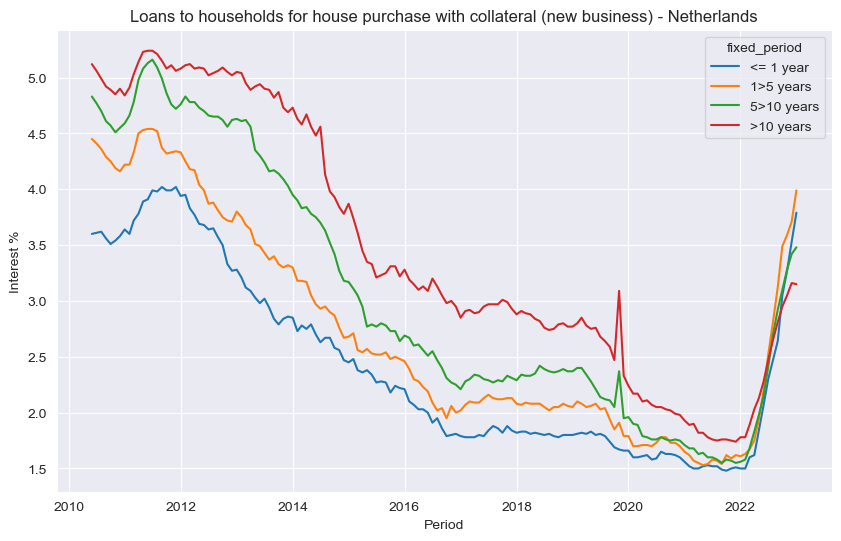

In [21]:
interest.lineplot()

In [24]:
from dateutil.parser import parse
pos_date = parse('28-02-2023')
bankmodel = assets.Bankmodel(pos_date = pos_date)
bankmodel.generate_mortgage_contracts(n = 150, df_i = interest.df)
bankmodel.df_mortgages.head()

category                 int32
fixed_period            object
years                    int64
start_date      datetime64[ns]
principal                int64
period          datetime64[ns]
interest               float64
dtype: object
contracts generated - now the cashflows


c:\users\m\skydrive\documents\github\rlalm\src\data\assets.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  
c:\users\m\skydrive\documents\github\rlalm\src\data\assets.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df


""


In [28]:
bankmodel.plot_contracts();

In [29]:
bankmodel.plot_cashflows()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'value_dt'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\M\AppData\Local\Temp\ipykernel_15832\733085973.py", line 1, in <module>
    bankmodel.plot_cashfl

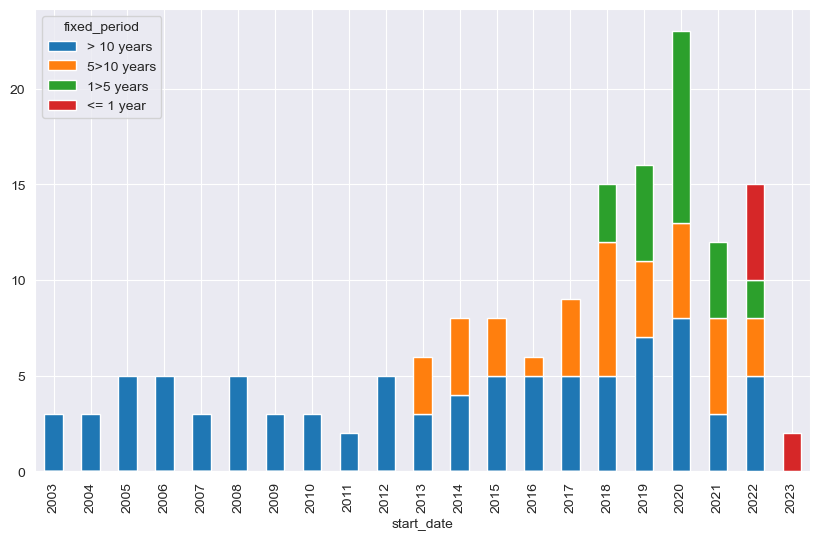

In [7]:
df.sort_values(['start_date','fixed_period']).pivot_table(index = df['start_date'].dt.year, 
               columns = ['fixed_period'], 
               values = 'principal', 
               aggfunc='count',
               sort=False).plot(kind = 'bar', stacked = True);

In [9]:
df_c = make_dataset.generate_mortgage_cashflows(df)
df_c.to_excel("../data/processed/cashflows.xlsx")

# Cut off all cashflows prior to position date
df_c = df_c[df_c['value_dt'] > pos_date]

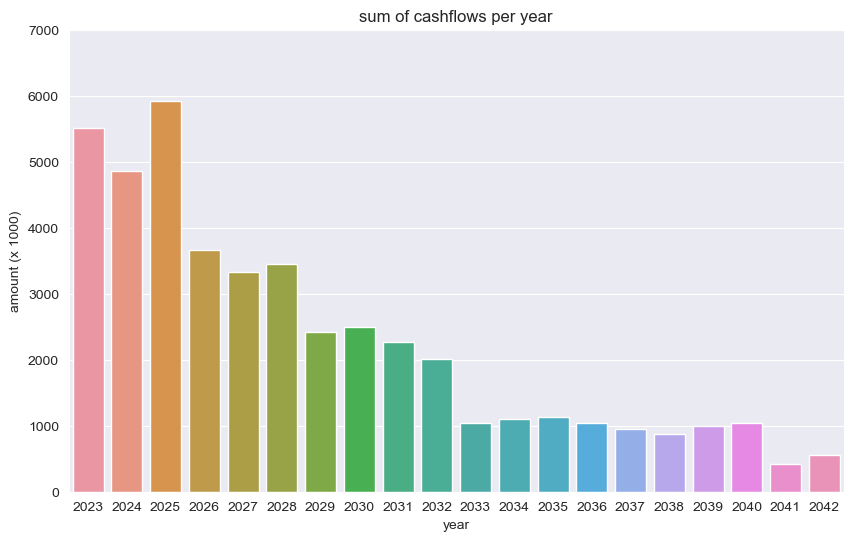

In [10]:
d = df_c[['cashflow']].groupby(df_c['value_dt'].dt.strftime('%Y')).sum()
d['cashflow'] = d['cashflow'] / 1000

ax = visualize.barplot(d, x= d.index, y = 'cashflow',x_label = 'year', y_label = 'amount (x 1000)', title = "sum of cashflows per year")
# using format string '{:.0f}' here but you can choose others
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(['{:0.0f}'.format(x) for x in ax.get_yticks().tolist()]);

### npv calculation

$$NPV = {{Cashflow} \over (1+i)^T}.$$
$$DF_0^T = [1+R_{zc}]^{-T})$$
where:
- $DF_0^T$  = a discount factor with maturity T
- $R_{zc}$ = A zero coupon interest rate
- $T$ = Maturity of the zero rate, in years (calculated as days/365)

In [88]:
# Get zero curve today
zerocurve = dataset.Zerocurve()
zerocurve.read_data()

2023-03-12 21:20:34.673 | INFO     | src.data.dataset:read_data:122 - reading zero curve data from ESW.


<Response [200]>

In [89]:
pos_date = parse('28-02-2023')
zerocurve.df.loc[pos_date]

,tenor,rate,value_dt
rate_dt,,,
2023-02-28,ON,3.052459,2023-03-01
2023-02-28,3 Months,3.052459,2023-05-28
2023-02-28,6 Months,3.369500,2023-08-28
2023-02-28,9 Months,3.390191,2023-11-28
2023-02-28,1 Year,3.282758,2024-02-28
2023-02-28,15 Months,3.135074,2024-05-28
2023-02-28,18 Months,2.989885,2024-08-28
2023-02-28,2 Years,2.766859,2025-02-28
2023-02-28,3 Years,2.588444,2026-02-28


In [92]:
df_interpol = zerocurve.interpolate(pos_date)

In [93]:
df_npv = df_c.merge(df_interpol, left_on = 'value_dt', right_on = df_interpol.index)
df_npv['pos_dt'] = pos_date
df_npv['year_frac'] = round((df_npv['value_dt'] -df_npv['pos_dt'] )/datetime.timedelta(365,0,0,0),5)
df_npv['df'] = 1 / (1 + df_npv['rate'] / 100 )**df_npv['year_frac']
df_npv['npv'] = round(df_npv['cashflow'] * df_npv['df'] ,2)


NameError: name 'df_c' is not defined

In [18]:
pd.set_option("display.precision", 5)
df_npv['npv'].sum()


38766169.81

In [ ]:
# De Volksbank Annual Report 
# initialize data of lists.

data = {'year':  [  2021,  2020,  2019,  2018,  2017,  2016,   2015,  2014,  2013,  2012,  2011 ],
        'loans': [ 50727, 50542, 50542, 50461, 50536, 48593,  49217, 52834, 53405, 49341, 51263 ] }
  
# Create DataFrame
df = pd.DataFrame(data)
df = df.sort_values(by = ['year'] )
df['growth'] = df['loans'].pct_change()
df = df.set_index('year')
df['prepayments'] =  - round((pre_payment_rate / 100) * df['loans'],4)
df['lgd']  = - round((pdf / 100) * df['loans'],0)
df['mortgages'] = round(df.loans / 200,0)
df['net_in_outflow'] = round((df['loans'].shift(-1) - ( df['loans'] + df['prepayments'] + df['lgd'] )   ) )
df.style.format(
    na_rep='',
    formatter =     
    {    
        "loans"       : "{:,.0f}",
        "growth"      : "{:0.2%}",        
        "mortgages"   : "{:,.0f}",
        "prepayments" : "{:,.0f}",    
        "lgd"         : "{:,.0f}", 
        "net_in_outflow"         : "{:,.0f}", 
    }
    
)

Non Maturity Deposits

#### Core vs Non Core balances
For saving deposits a cap on the average maturity of the core deposits is set at 4.5 years. 
In general 70% - 90% of the deposits can be classied as core capital. (See guidelines BCBS)